In [7]:
import pandas as pd
import spacy
from glob import glob
import matplotlib.pyplot  as plt

In [8]:
import os as os
os.chdir('D:\\ETH\\Robut')
os.getcwd()

'D:\\ETH\\Robut'

In [9]:
## Load spacy 
nlp = spacy.load('en')

In [10]:
filename = glob('cases/*txt')
filename1 = filename[:1000]
docId = []
year = []
sentence = {}
tokens = {}
POS = {}

In [8]:
## Read documents, tokenize sentences, add POS tags
for fname in filename1:
    Id =(fname.split("_")[-1][:-4]) # get docOd from filename
    docId.append(Id)
    year.append(fname.split("_")[0][-4:])
    text = open(fname,encoding="utf8").read()
    doc = nlp(text)
    sentence[Id] = list(doc.sents)
    t=[]  # initialize an array to hold tokens for each doc
    p=[]
    for token in doc:
        t.append(token.text)
        p.append(token.pos_)
    tokens[Id] = t
    POS[Id]=p
  

In [ ]:
## Question 1
num_sent = []
num_token = []
num_letter = []
for key, value in sentence.items():
    num_sent.append(len(value))
for key, value in tokens.items():
    num_token.append(len(value))
    count_letter = 0
    for token in value:
        count_letter += len(token)
    num_letter.append(count_letter)
    
print(num_sent)
print(num_token)
print(num_letter)

Text(0.5, 1.0, 'Number of Sentences')

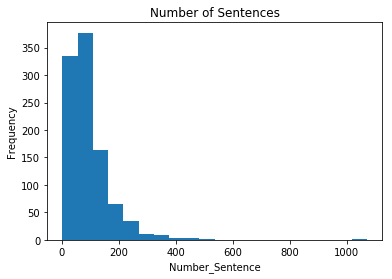

In [182]:
## Plot the frequency of number of sentences of each document
plt.hist(num_sent,bins=20)
plt.xlabel('Number_Sentence')
plt.ylabel('Frequency')
plt.title("Number of Sentences")

Text(0.5, 1.0, 'Number of Tokens')

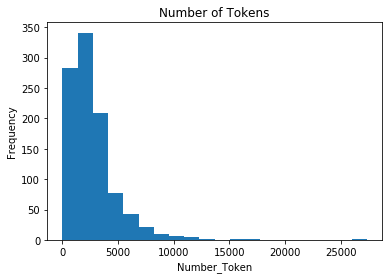

In [184]:
## Plot the frequency of number of tokens of each document
plt.hist(num_token,bins=20)
plt.xlabel('Number_Token')
plt.ylabel('Frequency')
plt.title("Number of Tokens")

Text(0.5, 1.0, 'Number of Letters')

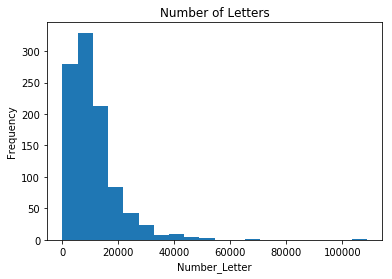

In [183]:
## Plot the frequency of number of letters of each document
plt.hist(num_letter,bins=20)
plt.xlabel('Number_Letter')
plt.ylabel('Frequency')
plt.title("Number of Letters")

In [9]:
## Question 2
count_noun=[]
count_verb=[]
count_adj=[]
for Id in docId:
    n=len([x for x in POS[Id] if x=="NOUN"])
    v=len([x for x in POS[Id] if x=="VERB"])
    a=len([x for x in POS[Id] if x=="ADJ"])
    count_noun.append(n)
    count_verb.append(v)
    count_adj.append(a)

data_count = pd.DataFrame({"Id":docId, "Year":year,"Count_N":count_noun, "Count_V":count_verb, "Count_A":count_adj})S

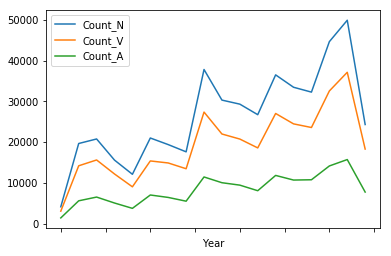

In [10]:
## Plot of counts of Noun, Verb adjective per yer
data_count.groupby(['Year'])[['Count_N','Count_V','Count_A']].sum().plot()

In [46]:
## Question 3
## Load nltk packages
import nltk
nltk.download('stopwords')
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luyang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
## normalize test: replace space and return, change all to lower case, remove puctuation, normalize numbers and remove stopwords
def normalize_text(doc):
    "Input spacy doc and return clean list of tokens"
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')  # replace space and return 
        lower = sent.lower() # all lower case
        nopunc = lower.translate(translator) # remove punctuation
        words = nopunc.split() # split into tokens
        nostop = [w for w in words if w not in stoplist] # remove stopwords
        no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
        stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
        tokens += stemmed # add to list of tokens for this speech
    return tokens

In [48]:
## Normalize the text
token_norm = {}
for fname in filename1:
    Id =(fname.split("_")[-1][:-4]) # get docId from filename
    text = open(fname,encoding="utf8").read()
    doc = nlp(text)
    token_norm[Id]= normalize_text(doc)

In [53]:
## Create trigrams and Filter the trigrams
from nltk import ngrams
from collections import Counter
from nltk.tag import perceptron
nltk.download('averaged_perceptron_tagger')
token_filter={}
for key, value in token_norm.items():
    token_tag_pair = nltk.pos_tag(token_norm[key])
    pair_trigram = ngrams(token_tag_pair,3)
    trigram_filter = []
    for i in list(pair_trigram):
        if i[2][1]=='NN':
            trigram_filter.append((i[0][0],i[1][0],i[2][0]))
    token_filter[key]=trigram_filter

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Luyang\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
## Extract each trigram 
trigram_all=[]
for key,value in token_filter.items():
    for v in value:
        trigram_all.append(v)     

In [59]:
print(trigram_all[0:10])

[('rose', 'circuit', 'judg'), ('judg', 'anoth', 'sugar'), ('anoth', 'sugar', 'case'), ('sugar', 'case', 'concern'), ('case', 'concern', 'transact'), ('concern', 'transact', 'aros'), ('aros', 'refer', 'seller'), ('refer', 'seller', 'buyer'), ('seller', 'buyer', 'bank'), ('first', 'last', 'parti')]


In [60]:
## Question 4
## Filter features according to the total counts
count_filter=[key for (key,value) in Counter(trigram_all).items() if (value > 5 and value <500)]

In [61]:
## Group by document
countByDoc={}
for key, value in token_filter.items():
    countByDoc[key] = Counter(value)

In [280]:
## Calculate the relative frequency of each gram within each document
df_feature = pd.DataFrame({'Id': docId})
for trigram in count_filter:
    freq = []
    for Id in docId:
        freq.append(countByDoc[Id][trigram]/sum(countByDoc[Id].values()))
    df_name = '-'.join(trigram)
    df_feature[df_name] = freq

In [305]:
## Create feature matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler( with_mean=False, with_std=True)
df_scaled = scaler.fit(df_feature.iloc[:,1:3802]).transform(df_feature.iloc[:,1:3802])
print(df_scaled)

[[ 6.05370033  7.22370292  6.20696427 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... 31.63859986 31.63859986
  31.63859986]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [293]:
## Use PCA to perform dimension reduction 
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
X = df_scaled
Xpca = pca.fit_transform(X)
#pca.explained_variance_ratio_
feature_pca = pd.DataFrame(np.hstack([np.reshape(docId,(1000,1)),Xpca]))

In [15]:
## Question 5
## Load labels
case_reversed = pd.read_csv('case_reversed.csv')
random_1000 = np.random.choice(range(0,case_reversed.shape[0]),size=1000)
y=case_reversed.iloc[random_1000,1]

In [389]:
## As the labels are all 0 for the first 1000 documents, resample 1000 documents
filename2 = pd.Series(filename)[random_1000].values
token_norm2 = {}
docId2 = []
for fname in filename2:
    Id = fname.split("_")[-1][:-4] # get docId from filename
    docId2.append(Id)
    text = open(fname,encoding="utf8").read()
    doc = nlp(text)
    token_norm2[Id]= normalize_text(doc)
token_filter2={}
for key, value in token_norm2.items():
    token_tag_pair = tagger.tag(token_norm2[key])
    pair_trigram = ngrams(token_tag_pair,3)
    trigram_filter = []
    for i in list(pair_trigram):
        if i[2][1]=='NN':
            trigram_filter.append((i[0][0],i[1][0],i[2][0]))
    token_filter2[key]=trigram_filter
    
trigram_all2=[]
for key,value in token_filter2.items():
    for v in value:
        trigram_all2.append(v)

count_filter2=[key for (key,value) in Counter(trigram_all2).items() if (value > 5 and value <500)]

countByDoc2={}
for key, value in token_filter2.items():
    countByDoc2[key] = Counter(value)
    


In [394]:
df_feature2 = pd.DataFrame({'Id': docId2})
for trigram in count_filter2:
    freq = []
    for Id in docId2:
        freq.append(countByDoc2[Id][trigram]/sum(countByDoc2[Id].values()))
    df_name = '-'.join(trigram)
    df_feature2[df_name] = freq
scaler2 = StandardScaler( with_mean=False, with_std=True)
df_scaled2 = scaler2.fit(df_feature2.iloc[:,1:df_feature2.shape[1]]).transform(df_feature2.iloc[:,1:df_feature2.shape[1]])
pca = PCA(n_components=1000)
X = df_scaled2
Xpca = pca.fit_transform(X)
#pca.explained_variance_ratio_
feature_pca2 = pd.DataFrame(np.hstack([np.reshape(docId2,(1000,1)),Xpca]))
feature_pca2['reversed'] = y.values

In [406]:
print(feature_pca2)

              0                       1                     2  \
0        X3BON8     -0.5567577168721299   -3.2379733557382235   
1        X3IMA7    -0.33266447097528673   -1.6785470371418725   
2        X3RLBR      -0.564891530992464   -1.0896274801888846   
3        X445L9     -0.4015035394275509    -1.049843731533461   
4        X3JBQE     -0.4307940256434787    -2.364768432614943   
5        X42L9N     -0.3908387657734964   -0.8888354466327025   
6        X44LF6     -0.3772426811320764   -1.5475121621602694   
7        X3J3NS     -0.3804407681043397   -0.5413515131244793   
8        X3MU7P     -0.4076637107526591   -1.3376434024193844   
9        X41G8E     -0.3798440353607379   -1.4419554027459542   
10       X4A3D1     -0.5313899137392226     4.569995901570177   
11       X3IL66    -0.09601132328169959     6.842405638218868   
12       X44026     -0.4686197184233924   -2.4144680664029776   
13       XABCUP    -0.35914836547744566     2.854796099777551   
14       X3P46A    -0.440

[1000 rows x 1002 columns]


In [407]:
## Create training set and testing set
from sklearn.model_selection import train_test_split
train, test = train_test_split(feature_pca2, test_size=0.2)

In [409]:
## Train the model wiht default values 
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(train.iloc[:,1:1000],train.loc[:,'reversed'])

C:\Users\Luyang\a1\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [428]:
## test prediction
test_prediction = logistic.predict(test.iloc[:,1:1000])
## accuracy 
test_accuracy = sum(test_prediction == test.loc[:,'reversed'])/len(test_prediction)
print(accuracy)
##f1 score
from sklearn.metrics import f1_score
print(f1_score(test.loc[:,'reversed'],test_prediction,average='macro'))

## train prediction
train_prediction = logistic.predict(train.iloc[:,1:1000])
## accuracy 
train_accuracy = sum(train_prediction == train.loc[:,'reversed'])/len(train_prediction)
print(train_accuracy)
##f1 score
from sklearn.metrics import f1_score
print(f1_score(train.loc[:,'reversed'],train_prediction,average='macro'))


0.625
0.6222709073052806
0.99875
0.9986526883078608


In [431]:
## Question 6 
## Create a list of values
params = {'C':[.1,1,5,10], 'penalty':['l1','l2']}
from sklearn.model_selection import GridSearchCV
logit = LogisticRegression()
grid = GridSearchCV(logit,params,n_jobs=-1)
grid.fit(feature_pca2.iloc[:,1:1000],feature_pca2.loc[:,'reversed'])

C:\Users\Luyang\a1\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Luyang\a1\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 1, 5, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [435]:
grid.best_params_
logit_best = grid.best_estimator_

In [436]:
from sklearn.model_selection import cross_val_predict
predict_cv = cross_val_predict(logit_best,feature_pca2.iloc[:,1:1000],feature_pca2.loc[:,'reversed'],method='decision_function')

C:\Users\Luyang\a1\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Luyang\a1\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Luyang\a1\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Luyang\a1\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


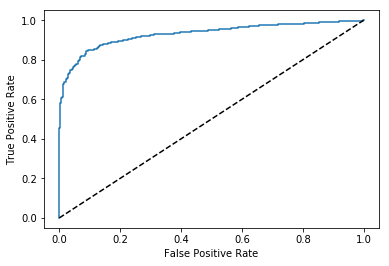

In [437]:
## ROC AUC curve of the best model
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(feature_pca2.loc[:,'reversed'], predict_cv)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [438]:
# ROC AUC score on the entire dataset 
from sklearn.metrics import roc_auc_score
print(roc_auc_score(feature_pca2.loc[:,'reversed'], predict_cv))

0.9305576528961277


In [23]:
## Question 8
## Treat each sentence as a document
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
sentence2 = []
for fname in filename2[0:500]:
    text = open(fname).read()
    sentences = sent_tokenize(text)
    sentence2.append(sentences)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luyang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
## Compute compound score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
compound_score = {}
for sent in sentence2:
    for s in sent:
        sid = SentimentIntensityAnalyzer()
        polarity = sid.polarity_scores(s)['compound']
        compound_score[s] = polarity

In [485]:
## Sort the score
score_sorted_key = sorted(compound_score, key=compound_score.get, reverse=False)
for key in score_sorted_key[0:10]:
    print (key, compound_score[key])

To succeed on a duress defense, this court requires that the defendant show: 1. that [she] was under an unlawful and present, imminent, and impending threat of such a nature as to induce a well-grounded apprehension of death or serious bodily injury; 2. that [she] had not recklessly or negligently placed herself in a situation in which it was probable that she would be forced to choose the criminal conduct; 3. that [she] had no reasonable legal alternative to violating the law, a chance both to refuse to do the criminal act and also to avoid the threatened harm; and 4. that a direct causal relationship may be reasonably anticipated between the criminal action taken and the avoidance of the threatened harm. -0.9924
It held that the regulations limiting visits infringed on prisoners' First Amendment right of intimate association and were not reasonably related to a valid penological objective, and that the permanent ban on visitors for two violations of the drug abuse policy infringed on

In [486]:
score_sorted_key_desc = sorted(compound_score, key=compound_score.get, reverse=True)
for key in score_sorted_key_desc[0:10]:
    print (key, compound_score[key])

384, 407, states the real party in interest principle very succinctly: but the "control" or "real party" concept trust beneficiaries, in contrast, have only "equitable" interests in their respective entities trust beneficiaries, should not be counted for diversity purposes Colonial Realty (emphasis supplied) (footnotes omitted) The same Comment discusses the holdings in the Colonial Realty and opposing Carlsberg Resources cases in the following reasoned manner: Colonial Realty Corp. v. Bache & Co. Chapman Great Southern rights, powers, and responsibilities Carlsberg Resources Corp. v. Cambria Savings & Loan Association Colonial Realty Carlsberg Resources Colonial Realty Chapman Great Southern Marshall Chapman Marshall Chapman Chapman A jurisdictional test that looks to the real parties to the controversy not only makes sense of the diversity precedents, but also accords well with the protective policy underlying the diversity jurisdiction, a policy which remains vital today Id. 0.994
A

It also charged conversion by the Trust Company of property of the Belt Company; also that the Trust Company occupied a fiduciary relation to the Belt Company, and by reason thereof had no right to charge any sums as profits; that the Trust Company in pursuance of a fraudulent plan sold worthless securities to the Belt Company; that the Trust Company fraudulently made overcharges on its books against a subsidiary company of the Belt Company, which charges afterward became charges against the Belt Company; that the Trust Company made sales of stocks and bonds for the Belt Company and reported the same as made at less than the actual figures, thereby securing for itself a profit; that the Trust Company caused the Belt Company to declare and pay dividends when it was insolvent, and that the Trust Company as a stockholder in the Belt Company received such dividends; that the Trust Company caused the Union Terminal Company, whose stock was owned by the Belt Company, to issue bonds and deliv

In [504]:
## Use TfidfVectorizer to compute tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
s_all = []
for sents in sentence2:
    for s in sents:
        s_all.append(s)
df_sent = pd.DataFrame(s_all)
tfidf = TfidfVectorizer(min_df=0.001, # at min .1% of docs
                        max_df=0.5,  # at most 50% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True)

X = tfidf.fit_transform(df_sent.iloc[:,0])


In [30]:
print(X)

  (0, 241)	0.22461614203610422
  (0, 562)	0.20709957297970233
  (0, 154)	0.21676985947031335
  (0, 301)	0.3003345448007632
  (0, 225)	0.21573458415691468
  (0, 881)	0.5920570237768771
  (0, 573)	0.2470481569157938
  (0, 152)	0.2820217363457712
  (0, 255)	0.2815345201359218
  (0, 202)	0.26739205011768735
  (0, 142)	0.28471945582768354
  (1, 301)	0.27392330271274695
  (1, 881)	0.26999593978579417
  (1, 255)	0.2567765410883367
  (1, 202)	0.48775550302386095
  (1, 556)	0.19581098759094767
  (1, 733)	0.2596813954206741
  (1, 464)	0.25604710985645057
  (1, 170)	0.2557591550643318
  (1, 751)	0.25462835580749554
  (1, 862)	0.17737714035381302
  (1, 12)	0.22026020244641611
  (1, 116)	0.16462863420903526
  (1, 141)	0.21209851438926972
  (1, 965)	0.20972118456311037
  :	:
  (74829, 908)	0.28761246089145887
  (74829, 490)	0.3372986715614217
  (74829, 946)	0.4129132472135668
  (74829, 390)	0.4536804534922852
  (74830, 490)	0.3183723514128521
  (74830, 575)	0.40637004846740843
  (74830, 390)	0.85644

In [513]:
## Question 9
## Compute cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X[:100])

In [554]:
## Similar sentences
selected  = np.where(np.logical_and(sim >= 0.7, sim<1)==True) ## pair1: 8,16   pair2:36,53
print(df_sent.iloc[[8,16],:])
print(df_sent.iloc[[36,53],:])

                                                    0
8   Phelps Dodge Corporation v. National Labor Rel...
16  After the decision in Phelps Dodge Corp. v. Na...
                                                0
36                    & O. R. Co. v. Smith (C. C.
53  & O. R. Co. v. Smith supra , also Smith v. B.


In [559]:
## Dissimilar sentences
selected  = np.where(np.logical_and(sim <= 0.1, sim>0)==True) ## e.g. pair1: 1,95   pair2:2,98
print(df_sent.iloc[[1,95],:])
print(df_sent.iloc[[2,98],:])

                                                    0
1   The most important issue in this case is wheth...
95  A few of the cases have put their decision aga...
                                                    0
2   We assume for argument that testimony may be, ...
98  They insist that the power must be sought else...


In [31]:
## Question 10 
## Apply KMeans
from sklearn.cluster import KMeans
num_clusters = 20
km = KMeans(n_clusters=num_clusters,n_jobs=-1)
km.fit(X)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
doc_clusters = km.labels_.tolist()
df_sent['cluster'] = doc_clusters

In [42]:
## Print out 5 sentences in each cluster
for i in range(1,21):
    print("cluster:",i)
    print(df_sent[df_sent['cluster']==i].iloc[0:5,0])

cluster: 1
193    New York Shipping Association v. FMC , 495 F.2...
236                                               Cir.).
502                              696 , 57 N.Y.S.2d 777 .
519    460 , 30 N.Y.S.2d 371, 374 , affirmed 1942, 28...
895    Co. v. Shumway , 62 Ariz. 359 , 158 P.2d 142 ,...
Name: 0, dtype: object
cluster: 2
31     Id .
124     Id.
131     Id.
137     Id.
141     Id.
Name: 0, dtype: object
cluster: 3
68892    Federal Rule of Criminal Procedure 11(c)(1) re...
Name: 0, dtype: object
cluster: 4
0     TAMM , Circuit Judge: This appeal constitutes...
2    The Federal Maritime Commission (FMC or Commis...
3    Recognizing that the reconciliation of the com...
4    For the reasons which follow, we remand to the...
5                                                   I.
Name: 0, dtype: object
cluster: 5
248     With FMC lightning threatening to strike twice...
842     Cumberland Coal Co. v. Board , 284 U. S. 23, 2...
1369    The Engineers' Committee cites phrases in case...
